# Con quarterrounds

In [20]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 0, 4,  8, 12)
      quarter_round(x, 1, 5,  9, 13)
      quarter_round(x, 2, 6, 10, 14)
      quarter_round(x, 3, 7, 11, 15)
      quarter_round(x, 0, 5, 10, 15)
      quarter_round(x, 1, 6, 11, 12)
      quarter_round(x, 2, 7,  8, 13)
      quarter_round(x, 3, 4,  9, 14)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))


assert chacha20_encrypt(
    b'Hello World', b'chacha20!') == b'\xeb\xe78\xad\xd5\xab\x18R\xe2O~'
assert chacha20_encrypt(
    b'\xeb\xe78\xad\xd5\xab\x18R\xe2O~', b'chacha20!') == b'Hello World'

# ---


def run_tests():
  import binascii
  uh = lambda x: binascii.unhexlify(bytes(x, 'ascii'))
  for i, (ciphertext, key, iv) in enumerate((
      (uh('76b8e0ada0f13d90405d6ae55386bd28bdd219b8a08ded1aa836efcc8b770dc7da41597c5157488d7724e03fb8d84a376a43b8f41518a11cc387b669'), uh('0000000000000000000000000000000000000000000000000000000000000000'), uh('0000000000000000')),
      (uh('4540f05a9f1fb296d7736e7b208e3c96eb4fe1834688d2604f450952ed432d41bbe2a0b6ea7566d2a5d1e7e20d42af2c53d792b1c43fea817e9ad275'), uh('0000000000000000000000000000000000000000000000000000000000000001'), uh('0000000000000000')),
      (uh('de9cba7bf3d69ef5e786dc63973f653a0b49e015adbff7134fcb7df137821031e85a050278a7084527214f73efc7fa5b5277062eb7a0433e445f41e3'), uh('0000000000000000000000000000000000000000000000000000000000000000'), uh('0000000000000001')),
      (uh('ef3fdfd6c61578fbf5cf35bd3dd33b8009631634d21e42ac33960bd138e50d32111e4caf237ee53ca8ad6426194a88545ddc497a0b466e7d6bbdb004'), uh('0000000000000000000000000000000000000000000000000000000000000000'), uh('0100000000000000')),
      (uh('f798a189f195e66982105ffb640bb7757f579da31602fc93ec01ac56f85ac3c134a4547b733b46413042c9440049176905d3be59ea1c53f15916155c2be8241a38008b9a26bc35941e2444177c8ade6689de95264986d95889fb60e84629c9bd9a5acb1cc118be563eb9b3a4a472f82e09a7e778492b562ef7130e88dfe031c79db9d4f7c7a899151b9a475032b63fc385245fe054e3dd5a97a5f576fe064025d3ce042c566ab2c507b138db853e3d6959660996546cc9c4a6eafdc777c040d70eaf46f76dad3979e5c5360c3317166a1c894c94a371876a94df7628fe4eaaf2ccb27d5aaae0ad7ad0f9d4b6ad3b54098746d4524d38407a6deb'), uh('000102030405060708090a0b0c0d0e0f101112131415161718191a1b1c1d1e1f'), uh('0001020304050607')),
      )):
    assert chacha20_encrypt(b'\0' * len(ciphertext), key, iv) == ciphertext
    print('Test %d OK.' % i)

In [21]:
!pip install bitstring

Defaulting to user installation because normal site-packages is not writeable


In [22]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)
print(original)

original = original.hex()
print(original)
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

b'\xe7\x02\xde_H\x0b\xaf\x8f\x12\x94Z\xa9\x9a^\x9aG\x05\xbb\xa6\xcc\xe2\xe5BZw0^\xae\xef\xc1\x1b\xc4'
e702de5f480baf8f12945aa99a5e9a4705bba6cce2e5425a77305eaeefc11bc4


In [23]:
exercici1 = []
exercici1.append(cambiosBits)
exercici1.append(cambiosPos)

# Sin quarterrounds 1

In [24]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 0, 5, 10, 15)
      quarter_round(x, 1, 6, 11, 12)
      quarter_round(x, 2, 7,  8, 13)
      quarter_round(x, 3, 4,  9, 14)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))

In [25]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)

original = original.hex()
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

In [26]:
exercici2 = []
exercici2.append(cambiosBits)
exercici2.append(cambiosPos)

# Sin quarteround 2

In [27]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 0, 4,  8, 12)
      quarter_round(x, 1, 5,  9, 13)
      quarter_round(x, 2, 6, 10, 14)
      quarter_round(x, 3, 7, 11, 15)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))

In [28]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)

original = original.hex()
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

In [29]:
exercici3 = []
exercici3.append(cambiosBits)
exercici3.append(cambiosPos)

# Sin quarteround 3

In [30]:
#! /usr/bin/python3
# by pts@fazekas.hu at Thu May 24 18:44:15 CEST 2018

"""Pure Python 3 implementation of the ChaCha20 stream cipher.
It works with Python 3.5 (and probably also earler Python 3.x).
Based on https://gist.github.com/cathalgarvey/0ce7dbae2aa9e3984adc
Based on Numpy implementation: https://gist.github.com/chiiph/6855750
Based on http://cr.yp.to/chacha.html
More info about ChaCha20: https://en.wikipedia.org/wiki/Salsa20
"""

import struct


def yield_chacha20_xor_stream(key, iv, position=0):
  """Generate the xor stream with the ChaCha20 cipher."""
  if not isinstance(position, int):
    raise TypeError
  if position & ~0xffffffff:
    raise ValueError('Position is not uint32.')
  if not isinstance(key, bytes):
    raise TypeError
  if not isinstance(iv, bytes):
    raise TypeError
  if len(key) != 32:
    raise ValueError
  if len(iv) != 8:
    raise ValueError

  def rotate(v, c):
    return ((v << c) & 0xffffffff) | v >> (32 - c)

  def quarter_round(x, a, b, c, d):
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 16)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 12)
    x[a] = (x[a] + x[b]) & 0xffffffff
    x[d] = rotate(x[d] ^ x[a], 8)
    x[c] = (x[c] + x[d]) & 0xffffffff
    x[b] = rotate(x[b] ^ x[c], 7)

  ctx = [0] * 16
  ctx[:4] = (1634760805, 857760878, 2036477234, 1797285236)
  ctx[4 : 12] = struct.unpack('<8L', key)
  ctx[12] = ctx[13] = position
  ctx[14 : 16] = struct.unpack('<LL', iv)
  while 1:
    x = list(ctx)
    for i in range(10):
      quarter_round(x, 1, 5,  9, 13)
      quarter_round(x, 2, 6, 10, 14)
      quarter_round(x, 3, 7, 11, 15)
      quarter_round(x, 0, 5, 10, 15)
      quarter_round(x, 2, 7,  8, 13)
      quarter_round(x, 3, 4,  9, 14)
    for c in struct.pack('<16L', *((x[i] + ctx[i]) & 0xffffffff for i in range(16))):
      yield c
    ctx[12] = (ctx[12] + 1) & 0xffffffff
    if ctx[12] == 0:
      ctx[13] = (ctx[13] + 1) & 0xffffffff


def chacha20_encrypt(data, key, iv=None, position=0):
  """Encrypt (or decrypt) with the ChaCha20 cipher."""
  if not isinstance(data, bytes):
    raise TypeError
  if iv is None:
    iv = b'\0' * 8
  if isinstance(key, bytes):
    if not key:
      raise ValueError('Key is empty.')
    if len(key) < 32:
      # TODO(pts): Do key derivation with PBKDF2 or something similar.
      key = (key * (32 // len(key) + 1))[:32]
    if len(key) > 32:
      raise ValueError('Key too long.')

  return bytes(a ^ b for a, b in
      zip(data, yield_chacha20_xor_stream(key, iv, position)))

In [31]:
original = chacha20_encrypt(b'0'*32, b'0'*32, position=1)

original = original.hex()
original = int(original, 16)

cambiosBits = [0] * 256
cambiosPos = [0] * 256

import binascii
for i in range(2,4097):
    modificada = (chacha20_encrypt(b'0'*32, b'0'*32, position=i))
    modificada = modificada.hex()
    modificada = int(modificada, 16)
    
    result = modificada ^ original
    
    cambiosBits[bin(result).count("1")] += 1
    
    bits = bin(result)[2:]
    for index, bit in enumerate(bits):
        if (bit == '1'):
            cambiosPos[index] += 1
cambiosPos = cambiosPos[1:]

In [32]:
exercici4 = []
exercici4.append(cambiosBits)
exercici4.append(cambiosPos)

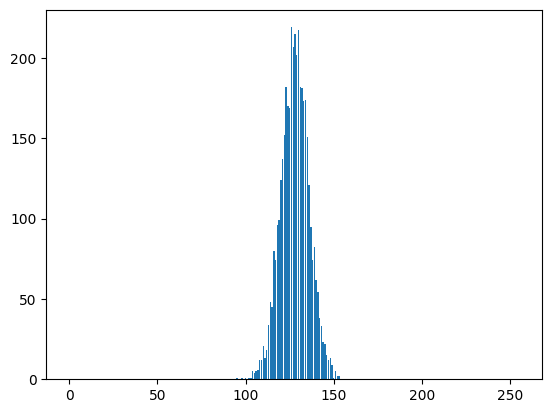

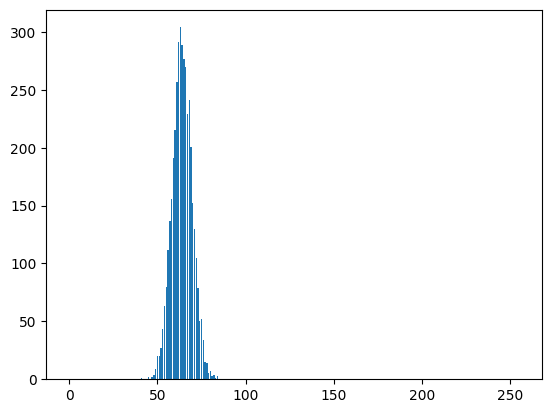

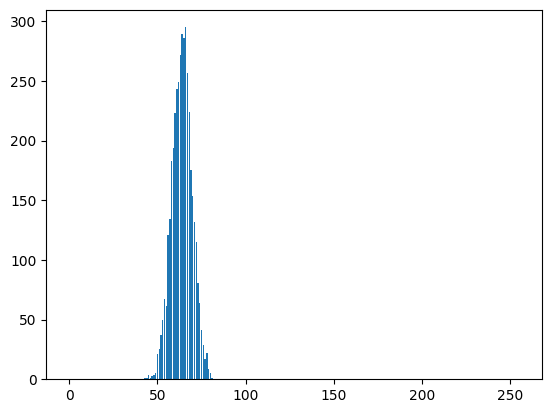

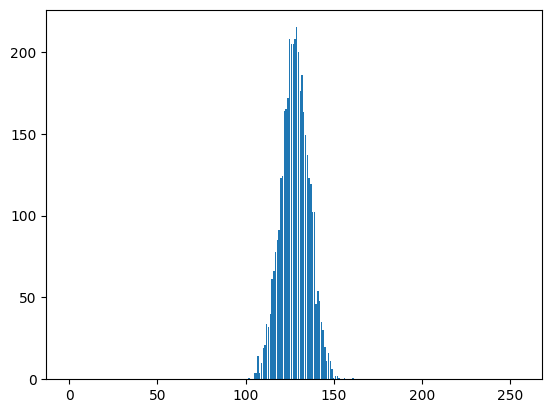

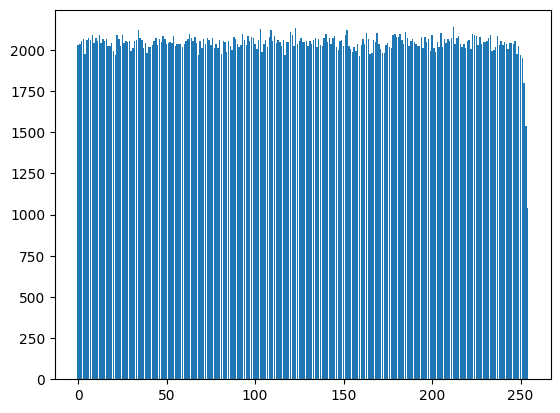

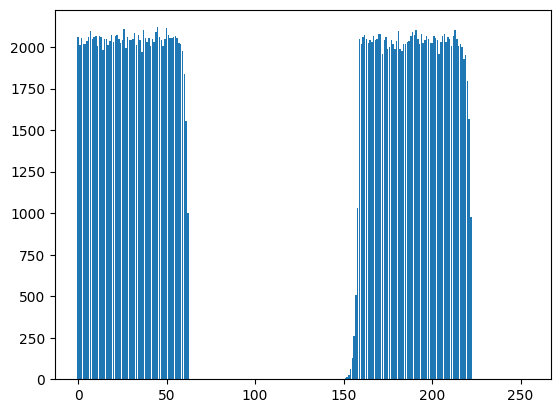

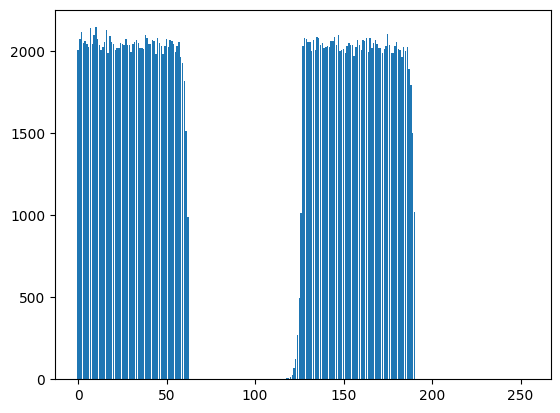

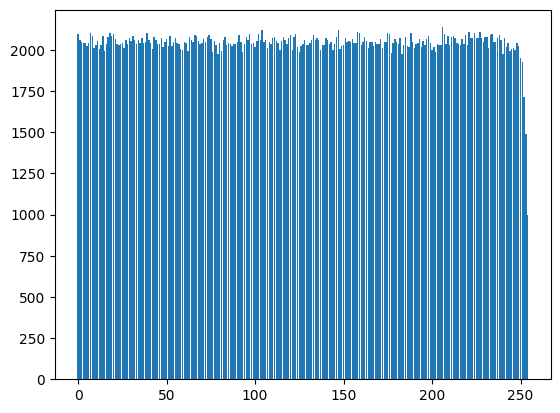

In [45]:
x = np.arange(0, 256)

y = exercici1[0]
plt.bar(x, y)
plt.show()
y = exercici2[0]
plt.bar(x, y)
plt.show()
y = exercici3[0]
plt.bar(x, y)
plt.show()
y = exercici4[0]
plt.bar(x, y)
plt.show()

x = np.arange(0, 255)
y = exercici1[1]
plt.bar(x, y)
plt.show()
y = exercici2[1]
plt.bar(x, y)
plt.show()
y = exercici3[1]
plt.bar(x, y)
plt.show()
y = exercici4[1]
plt.bar(x, y)
plt.show()